In [12]:
# LOCATION : https://github.com/purnasai/Dino_V2
import torch
import os

os.environ["XFORMERS_DISABLED"] = "1" # Switch to enable xFormers
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [13]:
# large model
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14').to(device)

Using cache found in /home/osero/.cache/torch/hub/facebookresearch_dinov2_main


In [14]:
# dinov2_vitl14

In [15]:
import requests
from PIL import Image
from torchvision import transforms
transform = transforms.Compose([           
                                transforms.Resize(256),                    
                                transforms.CenterCrop(224),               
                                transforms.ToTensor(),                    
                                transforms.Normalize(                      
                                mean=[0.485, 0.456, 0.406],                
                                std=[0.229, 0.224, 0.225]              
                                )])


transform1 = transforms.Compose([           
                                transforms.Resize(520),
                                transforms.CenterCrop(518), #should be multiple of model patch_size                 
                                transforms.ToTensor(),                    
                                transforms.Normalize(mean=0.5, std=0.2)
                                ])

In [16]:
patch_size = dinov2_vitl14.patch_size # patchsize=14

#520//14
patch_h  = 520//patch_size
patch_w  = 520//patch_size

# feat_dim = 384 # vits14
# feat_dim = 768 # vitb14
feat_dim = 1024 # vitl14
# feat_dim = 1536 # vitg14

# folder_path = "sign_language_photo/"
# total_features  = []
# with torch.no_grad():
#   for img_path in os.listdir(folder_path):
#     img_path = os.path.join(folder_path, img_path)
#     img = Image.open(img_path).convert('RGB')
#     img_t = transform1(img)
    
#     features_dict = dinov2_vitl14.forward_features(img_t.unsqueeze(0).to(device))
#     features = features_dict['x_norm_patchtokens']
#     total_features.append(features)

# total_features = torch.cat(total_features, dim=0)
# number_of_images = total_features.shape[0]
# total_features.shape

# total_features  = []

from sys import getsizeof

from torchvision.io import read_video
import torchvision.transforms.functional as F
total_features  = []
frames, _, _ = read_video(str("sign_language_video/0000.mp4"), output_format="TCHW")
counter = 0
with torch.no_grad():
  for frame in frames:
      img_t = transform1(F.to_pil_image(frame))
      counter += 1
      img_t_device = img_t.unsqueeze(0).to(device)
      features_dict = dinov2_vitl14.forward_features(img_t_device)
      features = features_dict['x_norm_patchtokens']
      total_features.append(features)

total_features = torch.cat(total_features, dim=0)
number_of_images = total_features.shape[0]
total_features.shape


/home/osero/miniconda3/envs/dinov2/lib/python3.10/site-packages/torchvision/io/video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


torch.Size([61, 1369, 1024])

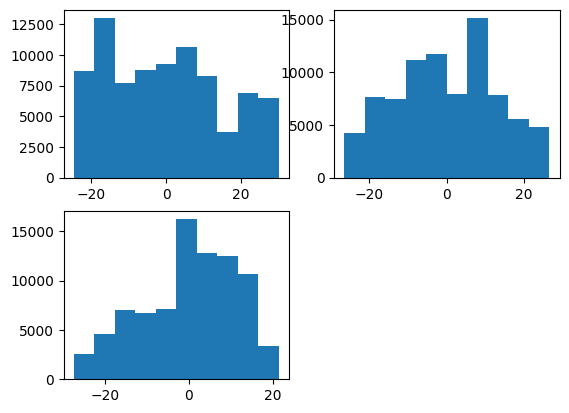

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# First PCA to Seperate Background
# sklearn expects 2d array for traning
total_features = total_features.reshape(number_of_images * patch_h * patch_w, feat_dim).cpu()#4(*H*w, 1024)

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)

# visualize PCA components for finding a proper threshold
# 3 histograms for 3 components
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

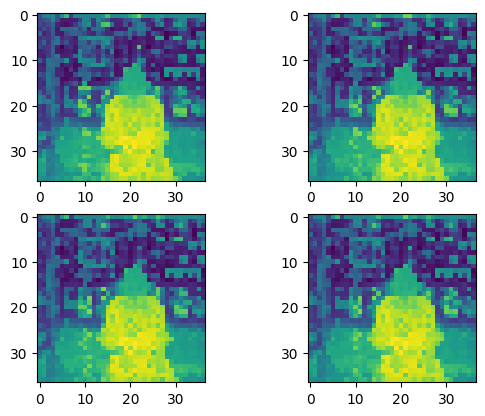

In [18]:
# min_max scale
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                     (pca_features[:, 0].max() - pca_features[:, 0].min())
#pca_features = sklearn.processing.minmax_scale(pca_features)

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features[i*patch_h*patch_w : (i+1)*patch_h*patch_w, 0].reshape(patch_h, patch_w))

plt.show()

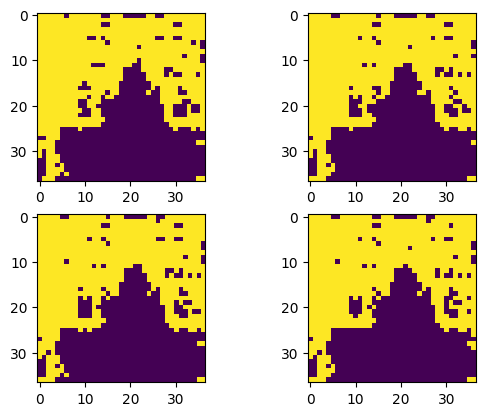

In [19]:
# segment/seperate the backgound and foreground using the first component
pca_features_bg = pca_features[:, 0] < 0.5 # from first histogram
pca_features_fg = ~pca_features_bg
import numpy as np
# plot the pca_features_bg
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()


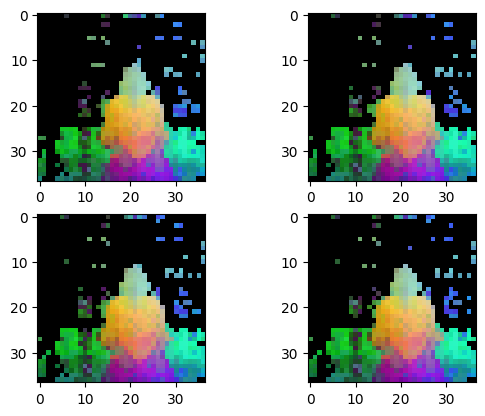

In [20]:
# 2nd PCA for only foreground patches
pca.fit(total_features[pca_features_fg]) 
pca_features_left = pca.transform(total_features[pca_features_fg])

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# reshaping to numpy image format
pca_features_rgb = pca_features_rgb.reshape(number_of_images, patch_h, patch_w, 3)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i])

plt.show()

In [21]:
import numpy as np
import cv2

fps = 30
sec = 2
 
video = cv2.VideoWriter('sign_language_video/test.mp4', cv2.VideoWriter_fourcc(*'mp4v'), float(fps), (patch_h*40, patch_w*40), True)

for i in range(number_of_images):
    abc = (pca_features_rgb[i]*255).astype('uint8')
    deg = abc.reshape(patch_h, patch_w, 3)
    deg = cv2.resize(deg, dsize=(patch_h*40, patch_w*40), interpolation=cv2.INTER_NEAREST)
    #deg = np.resize(deg, (patch_h*10, patch_w*10, 3))
    video.write(deg)
 
video.release()

In [22]:
# import cv2

# fps = 30
 
# video = cv2.VideoWriter('test.mp4', cv2.VideoWriter_fourcc(*'MJPG'), float(fps), (patch_h*10, patch_w*10), True)

# for i in range(number_of_images):
#     abc = (pca_features_rgb[i]*255).astype('uint8')
#     deg = abc.reshape(patch_h, patch_w, 3)
#     qwe = deg
#     video.write(deg)
 
# video.release()